In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import pickle
import random

rng = np.random.default_rng(926834)

In [2]:
#labels helpers and processing
def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def daynum_gen(date_time):
    '''converts date time objects to filename'''
    date_time = datetime.fromisoformat(date_time)
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

### Load data

In [3]:
base_path = "C:/Users/Matt/Dropbox/SnowComp/"
path1 = base_path+"ModisSnowImagesT.npy"
path2 = base_path+"ModisSnowImagesA.npy"
path3 = base_path+"ModisSnowImages_subT.npy"
path4 = base_path+"ModisSnowImages_subA.npy"

#submission small
path5 =base_path +"ModisSnowImages_subAT_small.npy"
path6 =base_path +"ModisSnowImages_AT_small.npy"

#train_features
path7 =base_path + "ModisSnowImages_trainfeat_T.npy"
path8 =base_path + "ModisSnowImages_trainfeat_A.npy"

#test_features
path9 =base_path + "ModisSnowImages_testfeat_T.npy"
path10=base_path + "ModisSnowImages_testfeat_A.npy"

In [4]:
#load cell ids, note Ts are correct, As are actual daynums 
path_id = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_idsT.pkl"
with open(path_id, 'rb') as handle:
    cell_ids = pickle.load( handle)

path_id = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_trainfeat.pkl"
with open(path_id, 'rb') as handle:
    cell_ids_train = pickle.load(handle)
    
path_id = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_testfeat.pkl"
with open(path_id, 'rb') as handle:
    cell_ids_test = pickle.load( handle)

In [5]:
# #Assemble submission dataset
# sub_dataT = np.load(path3) #be careful about memory, this is about 25-30 gigs ram
# sub_dataA = np.load(path4)

# sub_dataset = np.concatenate((sub_dataT[:,0:1,:,:],sub_dataA[:,0:1,:,:]), axis = 1)
# sub_dataset = sub_dataset/255
# np.save(path5,sub_dataset)

# sub_dataset = torch.Tensor(sub_dataset)
# del sub_dataT, sub_dataA

#### Read in and process `train_label` data

In [6]:
train_y = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/train_labels.csv")
train_y = pivot_df(train_y, 'cell_id').dropna()
train_y['date']=train_y['date'].map(daynum_gen)

#sort train_y so it has correct order before stripping labels
sorter = [idx +"-" +date for  idx, date  in cell_ids]
# with open(base_path + "train_idorder.pkl", 'wb') as handle:
#     pickle.dump(sorter, handle)

train_y['idx'] = train_y['cell_id'] +"-"+train_y['date']
train_y = train_y.set_index('idx')
train_y = train_y.loc[sorter]

In [7]:
#combine Aqua and Terra DSs
train_dataT = np.load(path1)
train_dataA = np.load(path2)

dataset = np.concatenate((train_dataT[:,0:1,:,:],train_dataA[:,0:1,:,:]), axis = 1)
# dataset = np.concatenate((train_dataT[:,(0,4),:,:],train_dataA[:,(0,4),:,:]), axis = 1)
# dataset = np.concatenate((train_dataT,train_dataA), axis = 1)
START_D = dataset.shape[1]

dataset= dataset/255
# np.save(path6,dataset)

del train_dataT
del train_dataA

#### Read in and order `train_features` data 

In [8]:
train_feat = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_train_features.csv")
train_feat = train_feat.rename(columns={"Unnamed: 0":"cell_id"})
train_feat = pivot_df(train_feat, 'cell_id').dropna()
train_feat['date']=train_feat['date'].map(daynum_gen)

#sort train_feat so it has correct order before stripping labels
sorter = [idx +"-" +date for  idx, date  in cell_ids_train]
with open(base_path + "trainfeat_idorder.pkl", 'wb') as handle:
    pickle.dump(sorter, handle)

train_feat['idx'] = train_feat['cell_id'] +"-"+train_feat['date']
train_feat = train_feat.set_index('idx')
train_feat = train_feat.loc[sorter]

In [9]:
#combine Aqua and Terra DSs
train_feat_dataT = np.load(path7)
train_feat_dataA = np.load(path8)

dataset_temp = np.concatenate((train_feat_dataT[:,0:1,:,:],train_feat_dataA[:,0:1,:,:]), axis = 1)
# dataset_temp = np.concatenate((train_feat_dataT[:,(0,4),:,:],train_feat_dataA[:,(0,4),:,:]), axis = 1)
# dataset_temp = np.concatenate((train_feat_dataT,train_feat_dataA), axis = 1)

dataset_temp= dataset_temp/255
# np.save(path6,dataset_temp)

del train_feat_dataT, train_feat_dataA

#### Read in and order `test_features` data

In [10]:
y_test = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_test_features.csv")
y_test = y_test.rename(columns={"Unnamed: 0":"cell_id"})
y_test = pivot_df(y_test, 'cell_id').dropna()
y_test['date']=y_test['date'].map(daynum_gen)

#sort train_feat so it has correct order before stripping labels
sorter = [idx +"-" +date for  idx, date  in cell_ids_test]
with open(base_path + "testfeat_idorder.pkl", 'wb') as handle:
    pickle.dump(sorter, handle)

y_test['idx'] = y_test['cell_id'] +"-"+y_test['date']
y_test = y_test.set_index('idx')
y_test = y_test.loc[sorter]

In [11]:
#combine Aqua and Terra DSs
test_feat_dataT = np.load(path9)
test_feat_dataA = np.load(path10)

dataset_test = np.concatenate((test_feat_dataT[:,0:1,:,:],test_feat_dataA[:,0:1,:,:]), axis = 1)
# dataset_temp = np.concatenate((test_feat_dataT[:,(0,4),:,:],test_feat_dataA[:,(0,4),:,:]), axis = 1)
# dataset_temp = np.concatenate((test_feat_dataT,test_feat_dataA), axis = 1)

dataset_test= dataset_test/255
# np.save(path6,dataset_temp)

del test_feat_dataT, test_feat_dataA

Holdout 15% of `train_labels` and smoosh everything together

In [12]:
#holdout 
mask = rng.random(len(dataset)) < 0.85

test_grid = dataset[~mask]
dataset = dataset[mask]
test_grid_y = train_y[~mask]
train_y = train_y[mask]

print(dataset.shape)
print(test_grid.shape)
print(test_grid_y.shape)
print(train_y.shape)

(77718, 2, 21, 21)
(13772, 2, 21, 21)
(13772, 3)
(77718, 3)


In [13]:
#training data
train_dataset = np.concatenate((dataset,
                   dataset_temp), axis = 0)
train_y = pd.concat((train_y, train_feat),
                    axis = 0)

train_y = train_y.reset_index(drop=True)
del dataset_temp, train_feat

#shuffle
p =rng.permutation(len(train_dataset))
train_y = train_y.loc[p]
train_dataset = train_dataset[p]

In [14]:
#test data
dataset_test = np.concatenate((dataset_test, test_grid),
                              axis = 0) 
y_test = pd.concat((y_test, test_grid_y),
                    axis = 0)

y_test = y_test.reset_index(drop=True)
del test_grid_y, test_grid

#shuffle
p =rng.permutation(len(dataset_test))
y_test = y_test.loc[p]
dataset_test = dataset_test[p]

In [15]:
data_path = "C:/Users/Matt/Dropbox/SnowComp/FinalData/"

train_y.to_csv(data_path + "train_y.csv", index = False)
y_test.to_csv(data_path + "test_y.csv", index = False)

np.save(data_path + "train_dataset.npy", train_dataset)
np.save(data_path + "test_datast.npy", dataset_test)

## Translate to Pytorch datatypes and validation

Redefine train and testing datasets 

In [16]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [17]:
#@title split training and testing
training_data = train_dataset
testing_data = dataset_test
train_rows = len(training_data)
test_rows = len(testing_data)

In [18]:
#@title Get data loaders
test_x, test_y = dataset_test, np.array(y_test['snowpack'])
test_x, test_y = torch.Tensor(test_x), torch.Tensor(test_y)
test_dataset = TensorDataset(test_x,test_y)
test_loader = DataLoader(test_dataset, batch_size = 256)

mini_x, mini_y = train_dataset, np.array(train_y['snowpack'])
mini_x, mini_y = torch.Tensor(mini_x), torch.Tensor(mini_y)

mini_dataset = TensorDataset(mini_x,
                              mini_y)
mini_loader = DataLoader(mini_dataset, batch_size=256)

# CNN

In [19]:
#@title Define simple CNN
# From: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# Also used: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

START_HW = 21

class Net(nn.Module):

    def _conv_calc(self, in_dim, pad, stride, k):
        out = int(np.floor((in_dim + 2 * pad - (k - 1) - 1) / stride + 1))
        return out

    def __init__(self, cdim1, cdim2,cdim3, kernel_sz, dropout,
                 ldim, print_dim = True):
        super(Net, self).__init__()
        
        #first layer
        self.conv1 = nn.Conv2d(START_D, cdim1, kernel_sz, 1)
        self.avgpool = nn.AvgPool2d(3, stride= 1)
        
        c1_dim = self._conv_calc(START_HW, 0, 1, kernel_sz)
        mp0_dim = self._conv_calc(c1_dim, 0, 1, 3)
        
        #second layer
        self.conv2 = nn.Conv2d(cdim1, cdim2, kernel_sz, 1)
        c2_dim = self._conv_calc(mp0_dim, 0, 1, kernel_sz)
        mp1_dim = self._conv_calc(c2_dim, 0, 1, 3)
        
        
        #third layer
        self.conv3 = nn.Conv2d(cdim2, cdim3, kernel_sz, 1)
        c3_dim = self._conv_calc(mp1_dim, 0, 1, kernel_sz)
        mp2_dim = self._conv_calc(c3_dim, 0, 1, 3)
        
        #fourth layer
        flattened_dim = cdim3 * mp2_dim * mp2_dim
        self.fc1 = nn.Linear(flattened_dim, ldim)
        self.fc2 = nn.Linear(ldim, 1)

        #extras
        self.dropout1 = nn.Dropout2d(dropout)
        self.dropout2 = nn.Dropout2d(dropout*2)
        self.BatchNorm1 = nn.BatchNorm2d(cdim1)
        self.BatchNorm3 = nn.BatchNorm2d(cdim3)
        
        if print_dim:
            print('c1 dim:', c1_dim)
            print('mp0 dim:', mp0_dim)
            print('c2 dim:', c2_dim)
            print('mp1 dim:', mp1_dim)
            print('c3 dim:', c3_dim)
            print('mp2 dim:', mp2_dim)
            print('flattened_dim',flattened_dim)
        
        
    def forward(self, x):
        #first layer
        x = self.conv1(x)
#         x = torch.tanh(x)
        x = F.relu(x)
        x = self.BatchNorm1(x)
        x = self.avgpool(x)
        
        #second layer
        x = self.dropout1(x)
        x = self.conv2(x)
#         x = torch.tanh(x)
        x = F.relu(x)
        x = self.avgpool(x)
        
        #third layer
        x = self.dropout2(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = F.relu(x)
        x = self.BatchNorm3(x)
        x = self.avgpool(x)
        
        #fourth layer
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        
        output = self.fc2(x)
        return output

    




In [20]:
#@title Helpers to get predictions and accuracy
def predict(cnn, x, as_numpy=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.eval()
    x =x.type(torch.FloatTensor).to(device)
    output = cnn(x)
    if as_numpy:
        output = output.flatten().cpu().detach().numpy() #detach removes gradients (bad)
        
    cnn.train()
    return output.squeeze()

def get_accuracy(cnn, x, y):
#     y = torch.from_numpy(y).to(device)
    outputs = predict(cnn, x,as_numpy = False)
    
#     print(y.shape, outputs.shape)
    loss = ((y-outputs)**2).sum()
    return round(loss.item(), 6)



In [21]:
#@title Setup net
cdim1=32; cdim2=18; cdim3 =8; kernel_sz=3; dropout=0.13; ldim=50; lrate = 0.0001
my_nn = Net(cdim1=cdim1, cdim2=cdim2,cdim3 =cdim3, kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"
)
my_nn.to(device)
optimizer = optim.Adam(my_nn.parameters(), lr=lrate)
criterion = nn.MSELoss(reduction = 'sum')

writer = SummaryWriter('runs/cnn_alldata')
write_index = 0

c1 dim: 19
mp0 dim: 17
c2 dim: 15
mp1 dim: 13
c3 dim: 11
mp2 dim: 9
flattened_dim 648


In [22]:
N_EPOCHS = 4000

test_loss = []
train_loss = []

#@title Run net
for epoch in range(N_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(mini_loader, 0):
        optimizer.zero_grad()
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = my_nn(inputs).squeeze()
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         for name, param in my_nn.named_parameters():
#             print(name, param.grad.abs().sum())

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            writer.add_scalar('Loss/train', running_loss , write_index)
        write_index += 1

#     val_acc = get_accuracy(my_nn, mini_x, mini_y)
    train_loss.append(running_loss/train_rows)
    writer.add_scalar('Acc/val', train_loss[-1], write_index)
    
    #calculate test loss.
    with torch.no_grad():
        
        running_tar_loss = 0
        for data, target in test_loader:
            running_tar_loss += get_accuracy(my_nn, data, target.to(device))


        test_loss.append(running_tar_loss / test_rows)
        writer.add_scalar('Test MSE', test_loss[-1], write_index)

    print(epoch, '/', N_EPOCHS,
          'complete, train:', round(np.sqrt(train_loss[-1]), 4),
          "test:", round(np.sqrt(test_loss[-1]), 4) )
            
            
            
    
writer.close()
print('Finished Training')
# 10.5, 9.63 best

0 / 4000 complete, train: 12.8333 test: 10.7681
1 / 4000 complete, train: 12.0577 test: 10.6608
2 / 4000 complete, train: 11.9705 test: 10.5947
3 / 4000 complete, train: 11.9082 test: 10.5408
4 / 4000 complete, train: 11.8526 test: 10.5059
5 / 4000 complete, train: 11.8151 test: 10.4742
6 / 4000 complete, train: 11.7781 test: 10.4655
7 / 4000 complete, train: 11.7573 test: 10.4367
8 / 4000 complete, train: 11.7227 test: 10.443
9 / 4000 complete, train: 11.6974 test: 10.4156
10 / 4000 complete, train: 11.6941 test: 10.4362
11 / 4000 complete, train: 11.678 test: 10.3848
12 / 4000 complete, train: 11.6588 test: 10.3769
13 / 4000 complete, train: 11.6257 test: 10.3763
14 / 4000 complete, train: 11.6228 test: 10.3651
15 / 4000 complete, train: 11.6054 test: 10.3434
16 / 4000 complete, train: 11.5937 test: 10.3404
17 / 4000 complete, train: 11.5737 test: 10.3285
18 / 4000 complete, train: 11.5719 test: 10.3382
19 / 4000 complete, train: 11.545 test: 10.3074
20 / 4000 complete, train: 11.545

168 / 4000 complete, train: 11.0711 test: 9.9629
169 / 4000 complete, train: 11.0604 test: 9.9804
170 / 4000 complete, train: 11.0748 test: 9.974
171 / 4000 complete, train: 11.0634 test: 9.9779
172 / 4000 complete, train: 11.0642 test: 9.9636
173 / 4000 complete, train: 11.0668 test: 9.9792
174 / 4000 complete, train: 11.0517 test: 9.9659
175 / 4000 complete, train: 11.0756 test: 9.9839
176 / 4000 complete, train: 11.0527 test: 9.9717
177 / 4000 complete, train: 11.0528 test: 9.9807
178 / 4000 complete, train: 11.0536 test: 9.9804
179 / 4000 complete, train: 11.049 test: 9.9996
180 / 4000 complete, train: 11.0499 test: 9.9762
181 / 4000 complete, train: 11.0489 test: 9.9622
182 / 4000 complete, train: 11.0337 test: 9.9749
183 / 4000 complete, train: 11.0418 test: 9.9574
184 / 4000 complete, train: 11.0426 test: 9.9748
185 / 4000 complete, train: 11.039 test: 9.9909
186 / 4000 complete, train: 11.0299 test: 9.9586
187 / 4000 complete, train: 11.0399 test: 9.9645
188 / 4000 complete, tr

337 / 4000 complete, train: 10.8575 test: 9.8965
338 / 4000 complete, train: 10.8554 test: 9.8877
339 / 4000 complete, train: 10.8414 test: 9.9163
340 / 4000 complete, train: 10.841 test: 9.8765
341 / 4000 complete, train: 10.8479 test: 9.9068
342 / 4000 complete, train: 10.8573 test: 9.8649
343 / 4000 complete, train: 10.853 test: 9.8856
344 / 4000 complete, train: 10.8452 test: 9.8838
345 / 4000 complete, train: 10.8416 test: 9.867
346 / 4000 complete, train: 10.841 test: 9.8794
347 / 4000 complete, train: 10.8419 test: 9.8393
348 / 4000 complete, train: 10.841 test: 9.8673
349 / 4000 complete, train: 10.8375 test: 9.8728
350 / 4000 complete, train: 10.8481 test: 9.8775
351 / 4000 complete, train: 10.8521 test: 9.8463
352 / 4000 complete, train: 10.8392 test: 9.8667
353 / 4000 complete, train: 10.8392 test: 9.8685
354 / 4000 complete, train: 10.8406 test: 9.8673
355 / 4000 complete, train: 10.8429 test: 9.8753
356 / 4000 complete, train: 10.8432 test: 9.8842
357 / 4000 complete, trai

506 / 4000 complete, train: 10.7184 test: 9.7838
507 / 4000 complete, train: 10.7244 test: 9.8167
508 / 4000 complete, train: 10.7255 test: 9.8355
509 / 4000 complete, train: 10.7289 test: 9.8268
510 / 4000 complete, train: 10.7331 test: 9.8358
511 / 4000 complete, train: 10.7073 test: 9.8086
512 / 4000 complete, train: 10.7169 test: 9.8442
513 / 4000 complete, train: 10.7098 test: 9.8229
514 / 4000 complete, train: 10.7306 test: 9.7958
515 / 4000 complete, train: 10.7116 test: 9.8597
516 / 4000 complete, train: 10.728 test: 9.8037
517 / 4000 complete, train: 10.7122 test: 9.8305
518 / 4000 complete, train: 10.7205 test: 9.8275
519 / 4000 complete, train: 10.723 test: 9.8462
520 / 4000 complete, train: 10.7221 test: 9.7953
521 / 4000 complete, train: 10.7171 test: 9.8238
522 / 4000 complete, train: 10.7052 test: 9.8105
523 / 4000 complete, train: 10.7025 test: 9.8333
524 / 4000 complete, train: 10.7092 test: 9.8479
525 / 4000 complete, train: 10.7141 test: 9.7901
526 / 4000 complete, t

674 / 4000 complete, train: 10.6296 test: 9.7857
675 / 4000 complete, train: 10.615 test: 9.775
676 / 4000 complete, train: 10.6187 test: 9.7892
677 / 4000 complete, train: 10.6212 test: 9.8092
678 / 4000 complete, train: 10.6152 test: 9.7937
679 / 4000 complete, train: 10.6132 test: 9.7682
680 / 4000 complete, train: 10.6163 test: 9.7625
681 / 4000 complete, train: 10.6242 test: 9.8023
682 / 4000 complete, train: 10.629 test: 9.7654
683 / 4000 complete, train: 10.6196 test: 9.8017
684 / 4000 complete, train: 10.6106 test: 9.7711
685 / 4000 complete, train: 10.6034 test: 9.7809
686 / 4000 complete, train: 10.6282 test: 9.774
687 / 4000 complete, train: 10.6224 test: 9.7788
688 / 4000 complete, train: 10.6188 test: 9.7678
689 / 4000 complete, train: 10.6138 test: 9.7994
690 / 4000 complete, train: 10.6078 test: 9.7989
691 / 4000 complete, train: 10.6185 test: 9.817
692 / 4000 complete, train: 10.6137 test: 9.7684
693 / 4000 complete, train: 10.6079 test: 9.783
694 / 4000 complete, train

842 / 4000 complete, train: 10.56 test: 9.7365
843 / 4000 complete, train: 10.5432 test: 9.7783
844 / 4000 complete, train: 10.5532 test: 9.7449
845 / 4000 complete, train: 10.5441 test: 9.7584
846 / 4000 complete, train: 10.5453 test: 9.7687
847 / 4000 complete, train: 10.5464 test: 9.7637
848 / 4000 complete, train: 10.5478 test: 9.7382
849 / 4000 complete, train: 10.5456 test: 9.7539
850 / 4000 complete, train: 10.5508 test: 9.7375
851 / 4000 complete, train: 10.5465 test: 9.7522
852 / 4000 complete, train: 10.5429 test: 9.7171
853 / 4000 complete, train: 10.5412 test: 9.7111
854 / 4000 complete, train: 10.5283 test: 9.7568
855 / 4000 complete, train: 10.5443 test: 9.7499
856 / 4000 complete, train: 10.525 test: 9.7609
857 / 4000 complete, train: 10.5473 test: 9.7663
858 / 4000 complete, train: 10.5425 test: 9.7297
859 / 4000 complete, train: 10.5321 test: 9.7577
860 / 4000 complete, train: 10.5273 test: 9.7577
861 / 4000 complete, train: 10.5379 test: 9.738
862 / 4000 complete, tra

1010 / 4000 complete, train: 10.5023 test: 9.7411
1011 / 4000 complete, train: 10.4844 test: 9.7727
1012 / 4000 complete, train: 10.4839 test: 9.7304
1013 / 4000 complete, train: 10.4889 test: 9.7613
1014 / 4000 complete, train: 10.4923 test: 9.76
1015 / 4000 complete, train: 10.4959 test: 9.7616
1016 / 4000 complete, train: 10.4774 test: 9.7244
1017 / 4000 complete, train: 10.4832 test: 9.74
1018 / 4000 complete, train: 10.484 test: 9.7608
1019 / 4000 complete, train: 10.4829 test: 9.7693
1020 / 4000 complete, train: 10.4854 test: 9.7185
1021 / 4000 complete, train: 10.487 test: 9.7482
1022 / 4000 complete, train: 10.4932 test: 9.741
1023 / 4000 complete, train: 10.4873 test: 9.7556
1024 / 4000 complete, train: 10.4755 test: 9.7345
1025 / 4000 complete, train: 10.469 test: 9.7326
1026 / 4000 complete, train: 10.4828 test: 9.7248
1027 / 4000 complete, train: 10.4801 test: 9.7204
1028 / 4000 complete, train: 10.4786 test: 9.7457
1029 / 4000 complete, train: 10.4667 test: 9.7606
1030 / 4

1175 / 4000 complete, train: 10.4303 test: 9.7357
1176 / 4000 complete, train: 10.4465 test: 9.736
1177 / 4000 complete, train: 10.4445 test: 9.733
1178 / 4000 complete, train: 10.4319 test: 9.7317
1179 / 4000 complete, train: 10.4564 test: 9.7389
1180 / 4000 complete, train: 10.4406 test: 9.778
1181 / 4000 complete, train: 10.4391 test: 9.7416
1182 / 4000 complete, train: 10.4324 test: 9.7217
1183 / 4000 complete, train: 10.4221 test: 9.7584
1184 / 4000 complete, train: 10.4336 test: 9.7254
1185 / 4000 complete, train: 10.4402 test: 9.7477
1186 / 4000 complete, train: 10.4373 test: 9.7412
1187 / 4000 complete, train: 10.4417 test: 9.7689
1188 / 4000 complete, train: 10.4337 test: 9.7364
1189 / 4000 complete, train: 10.4291 test: 9.7223
1190 / 4000 complete, train: 10.4258 test: 9.7229
1191 / 4000 complete, train: 10.4323 test: 9.7417
1192 / 4000 complete, train: 10.4296 test: 9.7165
1193 / 4000 complete, train: 10.4467 test: 9.7225
1194 / 4000 complete, train: 10.4346 test: 9.7227
119

1340 / 4000 complete, train: 10.3986 test: 9.7139
1341 / 4000 complete, train: 10.397 test: 9.7189
1342 / 4000 complete, train: 10.3918 test: 9.7325
1343 / 4000 complete, train: 10.3908 test: 9.7459
1344 / 4000 complete, train: 10.3954 test: 9.6938
1345 / 4000 complete, train: 10.3931 test: 9.7357
1346 / 4000 complete, train: 10.4029 test: 9.7304
1347 / 4000 complete, train: 10.3949 test: 9.7353
1348 / 4000 complete, train: 10.3956 test: 9.7235
1349 / 4000 complete, train: 10.3893 test: 9.7063
1350 / 4000 complete, train: 10.4048 test: 9.7018
1351 / 4000 complete, train: 10.3985 test: 9.7405
1352 / 4000 complete, train: 10.4012 test: 9.7583
1353 / 4000 complete, train: 10.4122 test: 9.7417
1354 / 4000 complete, train: 10.4154 test: 9.7224
1355 / 4000 complete, train: 10.3901 test: 9.6904
1356 / 4000 complete, train: 10.3973 test: 9.73
1357 / 4000 complete, train: 10.4117 test: 9.7079
1358 / 4000 complete, train: 10.3983 test: 9.6975
1359 / 4000 complete, train: 10.3981 test: 9.7335
136

1505 / 4000 complete, train: 10.3578 test: 9.7627
1506 / 4000 complete, train: 10.3616 test: 9.7595
1507 / 4000 complete, train: 10.3681 test: 9.7375
1508 / 4000 complete, train: 10.3732 test: 9.7419
1509 / 4000 complete, train: 10.3666 test: 9.7382
1510 / 4000 complete, train: 10.3635 test: 9.7462
1511 / 4000 complete, train: 10.3725 test: 9.7215
1512 / 4000 complete, train: 10.364 test: 9.6866
1513 / 4000 complete, train: 10.3586 test: 9.7392
1514 / 4000 complete, train: 10.3578 test: 9.717
1515 / 4000 complete, train: 10.3668 test: 9.7014
1516 / 4000 complete, train: 10.3634 test: 9.7515
1517 / 4000 complete, train: 10.3472 test: 9.7412
1518 / 4000 complete, train: 10.3623 test: 9.7236
1519 / 4000 complete, train: 10.361 test: 9.7342
1520 / 4000 complete, train: 10.3628 test: 9.7333
1521 / 4000 complete, train: 10.3484 test: 9.7596
1522 / 4000 complete, train: 10.3611 test: 9.7544
1523 / 4000 complete, train: 10.365 test: 9.707
1524 / 4000 complete, train: 10.3478 test: 9.7153
1525 

1670 / 4000 complete, train: 10.3338 test: 9.7474
1671 / 4000 complete, train: 10.3306 test: 9.7112
1672 / 4000 complete, train: 10.3353 test: 9.7056
1673 / 4000 complete, train: 10.343 test: 9.7294
1674 / 4000 complete, train: 10.3273 test: 9.7468
1675 / 4000 complete, train: 10.3303 test: 9.7219
1676 / 4000 complete, train: 10.3323 test: 9.7531
1677 / 4000 complete, train: 10.3432 test: 9.7246
1678 / 4000 complete, train: 10.3325 test: 9.7281
1679 / 4000 complete, train: 10.3335 test: 9.7449
1680 / 4000 complete, train: 10.3286 test: 9.716
1681 / 4000 complete, train: 10.3397 test: 9.7107
1682 / 4000 complete, train: 10.3335 test: 9.7618
1683 / 4000 complete, train: 10.337 test: 9.765
1684 / 4000 complete, train: 10.3349 test: 9.7216
1685 / 4000 complete, train: 10.3515 test: 9.7065
1686 / 4000 complete, train: 10.3411 test: 9.7477
1687 / 4000 complete, train: 10.3326 test: 9.7577
1688 / 4000 complete, train: 10.3346 test: 9.732
1689 / 4000 complete, train: 10.3366 test: 9.7523
1690 

1835 / 4000 complete, train: 10.307 test: 9.6891
1836 / 4000 complete, train: 10.3075 test: 9.7272
1837 / 4000 complete, train: 10.3126 test: 9.7
1838 / 4000 complete, train: 10.2902 test: 9.7169
1839 / 4000 complete, train: 10.3225 test: 9.7148
1840 / 4000 complete, train: 10.3091 test: 9.7176
1841 / 4000 complete, train: 10.3093 test: 9.7629
1842 / 4000 complete, train: 10.3239 test: 9.7523
1843 / 4000 complete, train: 10.3164 test: 9.728
1844 / 4000 complete, train: 10.3233 test: 9.7232
1845 / 4000 complete, train: 10.3205 test: 9.7181
1846 / 4000 complete, train: 10.3037 test: 9.7557
1847 / 4000 complete, train: 10.3036 test: 9.761
1848 / 4000 complete, train: 10.3098 test: 9.7025
1849 / 4000 complete, train: 10.3103 test: 9.739
1850 / 4000 complete, train: 10.3223 test: 9.7197
1851 / 4000 complete, train: 10.3173 test: 9.7214
1852 / 4000 complete, train: 10.3071 test: 9.7229
1853 / 4000 complete, train: 10.3044 test: 9.7791
1854 / 4000 complete, train: 10.3277 test: 9.7458
1855 / 

2000 / 4000 complete, train: 10.2937 test: 9.725
2001 / 4000 complete, train: 10.2949 test: 9.7581
2002 / 4000 complete, train: 10.2861 test: 9.7153
2003 / 4000 complete, train: 10.2729 test: 9.7254
2004 / 4000 complete, train: 10.3047 test: 9.6758
2005 / 4000 complete, train: 10.2942 test: 9.7305
2006 / 4000 complete, train: 10.2889 test: 9.7128
2007 / 4000 complete, train: 10.2976 test: 9.7261
2008 / 4000 complete, train: 10.2769 test: 9.7293
2009 / 4000 complete, train: 10.2876 test: 9.7224
2010 / 4000 complete, train: 10.2852 test: 9.7135
2011 / 4000 complete, train: 10.2768 test: 9.6666
2012 / 4000 complete, train: 10.2703 test: 9.7069
2013 / 4000 complete, train: 10.2908 test: 9.7154
2014 / 4000 complete, train: 10.2833 test: 9.7183
2015 / 4000 complete, train: 10.2988 test: 9.7188
2016 / 4000 complete, train: 10.2894 test: 9.709
2017 / 4000 complete, train: 10.2791 test: 9.7315
2018 / 4000 complete, train: 10.2851 test: 9.706
2019 / 4000 complete, train: 10.2866 test: 9.7408
202

2165 / 4000 complete, train: 10.2603 test: 9.699
2166 / 4000 complete, train: 10.2552 test: 9.7389
2167 / 4000 complete, train: 10.2672 test: 9.7508
2168 / 4000 complete, train: 10.2699 test: 9.7427
2169 / 4000 complete, train: 10.2784 test: 9.7319
2170 / 4000 complete, train: 10.2637 test: 9.7254
2171 / 4000 complete, train: 10.2633 test: 9.7024
2172 / 4000 complete, train: 10.2703 test: 9.7865
2173 / 4000 complete, train: 10.257 test: 9.7566
2174 / 4000 complete, train: 10.2606 test: 9.7183
2175 / 4000 complete, train: 10.2834 test: 9.7506
2176 / 4000 complete, train: 10.2592 test: 9.7204
2177 / 4000 complete, train: 10.2774 test: 9.7181
2178 / 4000 complete, train: 10.2744 test: 9.7208
2179 / 4000 complete, train: 10.2667 test: 9.731
2180 / 4000 complete, train: 10.268 test: 9.7382
2181 / 4000 complete, train: 10.2658 test: 9.7324
2182 / 4000 complete, train: 10.2606 test: 9.7306
2183 / 4000 complete, train: 10.2524 test: 9.7245
2184 / 4000 complete, train: 10.2693 test: 9.7035
2185

2330 / 4000 complete, train: 10.2556 test: 9.684
2331 / 4000 complete, train: 10.2538 test: 9.6926
2332 / 4000 complete, train: 10.2588 test: 9.7191
2333 / 4000 complete, train: 10.2566 test: 9.7337
2334 / 4000 complete, train: 10.249 test: 9.7347
2335 / 4000 complete, train: 10.238 test: 9.7186
2336 / 4000 complete, train: 10.2507 test: 9.6969
2337 / 4000 complete, train: 10.227 test: 9.7244
2338 / 4000 complete, train: 10.2449 test: 9.7516
2339 / 4000 complete, train: 10.2463 test: 9.7394
2340 / 4000 complete, train: 10.2438 test: 9.7262
2341 / 4000 complete, train: 10.253 test: 9.7072
2342 / 4000 complete, train: 10.2562 test: 9.7141
2343 / 4000 complete, train: 10.2552 test: 9.6986
2344 / 4000 complete, train: 10.254 test: 9.7165
2345 / 4000 complete, train: 10.2432 test: 9.7505
2346 / 4000 complete, train: 10.2379 test: 9.7082
2347 / 4000 complete, train: 10.2396 test: 9.7312
2348 / 4000 complete, train: 10.2386 test: 9.7234
2349 / 4000 complete, train: 10.2326 test: 9.7395
2350 /

2495 / 4000 complete, train: 10.2249 test: 9.734
2496 / 4000 complete, train: 10.2141 test: 9.7175
2497 / 4000 complete, train: 10.2258 test: 9.7419
2498 / 4000 complete, train: 10.2404 test: 9.7307
2499 / 4000 complete, train: 10.232 test: 9.7211
2500 / 4000 complete, train: 10.2336 test: 9.7338
2501 / 4000 complete, train: 10.2262 test: 9.7299
2502 / 4000 complete, train: 10.2155 test: 9.6968
2503 / 4000 complete, train: 10.2322 test: 9.751
2504 / 4000 complete, train: 10.2319 test: 9.7192
2505 / 4000 complete, train: 10.2146 test: 9.7212
2506 / 4000 complete, train: 10.2365 test: 9.7107
2507 / 4000 complete, train: 10.2221 test: 9.711
2508 / 4000 complete, train: 10.2389 test: 9.7314
2509 / 4000 complete, train: 10.2435 test: 9.7661
2510 / 4000 complete, train: 10.2231 test: 9.7183
2511 / 4000 complete, train: 10.249 test: 9.7418
2512 / 4000 complete, train: 10.2369 test: 9.7406
2513 / 4000 complete, train: 10.236 test: 9.7482
2514 / 4000 complete, train: 10.2163 test: 9.7077
2515 /

2660 / 4000 complete, train: 10.2084 test: 9.7607
2661 / 4000 complete, train: 10.2095 test: 9.7352
2662 / 4000 complete, train: 10.2223 test: 9.7564
2663 / 4000 complete, train: 10.214 test: 9.7482
2664 / 4000 complete, train: 10.213 test: 9.7332
2665 / 4000 complete, train: 10.2042 test: 9.736
2666 / 4000 complete, train: 10.1958 test: 9.7438
2667 / 4000 complete, train: 10.2153 test: 9.7204
2668 / 4000 complete, train: 10.215 test: 9.7033
2669 / 4000 complete, train: 10.2019 test: 9.7695
2670 / 4000 complete, train: 10.2078 test: 9.7387
2671 / 4000 complete, train: 10.2013 test: 9.7482
2672 / 4000 complete, train: 10.2141 test: 9.7325
2673 / 4000 complete, train: 10.2164 test: 9.7367
2674 / 4000 complete, train: 10.2062 test: 9.7362
2675 / 4000 complete, train: 10.2338 test: 9.7254
2676 / 4000 complete, train: 10.21 test: 9.7746
2677 / 4000 complete, train: 10.2072 test: 9.734
2678 / 4000 complete, train: 10.2109 test: 9.7248
2679 / 4000 complete, train: 10.2114 test: 9.7288
2680 / 

2825 / 4000 complete, train: 10.1936 test: 9.7448
2826 / 4000 complete, train: 10.1931 test: 9.7719
2827 / 4000 complete, train: 10.2128 test: 9.7235
2828 / 4000 complete, train: 10.2028 test: 9.7252
2829 / 4000 complete, train: 10.1999 test: 9.7228
2830 / 4000 complete, train: 10.1901 test: 9.7189
2831 / 4000 complete, train: 10.2022 test: 9.7754
2832 / 4000 complete, train: 10.2013 test: 9.7278
2833 / 4000 complete, train: 10.1992 test: 9.7283
2834 / 4000 complete, train: 10.1799 test: 9.7748
2835 / 4000 complete, train: 10.2071 test: 9.7641
2836 / 4000 complete, train: 10.2036 test: 9.7313
2837 / 4000 complete, train: 10.1866 test: 9.7489
2838 / 4000 complete, train: 10.1864 test: 9.7796
2839 / 4000 complete, train: 10.206 test: 9.7349
2840 / 4000 complete, train: 10.2117 test: 9.7156
2841 / 4000 complete, train: 10.2127 test: 9.7503
2842 / 4000 complete, train: 10.208 test: 9.7566
2843 / 4000 complete, train: 10.1834 test: 9.7159
2844 / 4000 complete, train: 10.1994 test: 9.7289
28

2990 / 4000 complete, train: 10.1897 test: 9.7781
2991 / 4000 complete, train: 10.1742 test: 9.7165
2992 / 4000 complete, train: 10.1956 test: 9.7342
2993 / 4000 complete, train: 10.1898 test: 9.7829
2994 / 4000 complete, train: 10.1694 test: 9.7671
2995 / 4000 complete, train: 10.1796 test: 9.7465
2996 / 4000 complete, train: 10.1937 test: 9.7333
2997 / 4000 complete, train: 10.1962 test: 9.7312
2998 / 4000 complete, train: 10.1846 test: 9.7609
2999 / 4000 complete, train: 10.1722 test: 9.7911
3000 / 4000 complete, train: 10.1916 test: 9.7909
3001 / 4000 complete, train: 10.1873 test: 9.7443
3002 / 4000 complete, train: 10.174 test: 9.7782
3003 / 4000 complete, train: 10.1794 test: 9.7668
3004 / 4000 complete, train: 10.1859 test: 9.7486
3005 / 4000 complete, train: 10.1846 test: 9.7343
3006 / 4000 complete, train: 10.1677 test: 9.753
3007 / 4000 complete, train: 10.1599 test: 9.7538
3008 / 4000 complete, train: 10.1958 test: 9.7708
3009 / 4000 complete, train: 10.183 test: 9.763
3010

3155 / 4000 complete, train: 10.1611 test: 9.7277
3156 / 4000 complete, train: 10.1626 test: 9.7382
3157 / 4000 complete, train: 10.1798 test: 9.7625
3158 / 4000 complete, train: 10.1704 test: 9.7356
3159 / 4000 complete, train: 10.163 test: 9.7581
3160 / 4000 complete, train: 10.1774 test: 9.7558
3161 / 4000 complete, train: 10.1634 test: 9.7275
3162 / 4000 complete, train: 10.1559 test: 9.7566
3163 / 4000 complete, train: 10.1686 test: 9.7454
3164 / 4000 complete, train: 10.1637 test: 9.7435
3165 / 4000 complete, train: 10.1735 test: 9.7936
3166 / 4000 complete, train: 10.1721 test: 9.7304
3167 / 4000 complete, train: 10.166 test: 9.7462
3168 / 4000 complete, train: 10.1601 test: 9.765
3169 / 4000 complete, train: 10.1691 test: 9.8075
3170 / 4000 complete, train: 10.1711 test: 9.7927
3171 / 4000 complete, train: 10.1612 test: 9.7297
3172 / 4000 complete, train: 10.1682 test: 9.7514
3173 / 4000 complete, train: 10.1633 test: 9.7438
3174 / 4000 complete, train: 10.1605 test: 9.78
3175 

3320 / 4000 complete, train: 10.1583 test: 9.753
3321 / 4000 complete, train: 10.147 test: 9.7539
3322 / 4000 complete, train: 10.1519 test: 9.7818
3323 / 4000 complete, train: 10.1517 test: 9.7683
3324 / 4000 complete, train: 10.1742 test: 9.7966
3325 / 4000 complete, train: 10.1615 test: 9.7441
3326 / 4000 complete, train: 10.1583 test: 9.7343
3327 / 4000 complete, train: 10.1497 test: 9.7546
3328 / 4000 complete, train: 10.1643 test: 9.7502
3329 / 4000 complete, train: 10.1639 test: 9.722
3330 / 4000 complete, train: 10.1577 test: 9.7444
3331 / 4000 complete, train: 10.1575 test: 9.7538
3332 / 4000 complete, train: 10.1514 test: 9.7563
3333 / 4000 complete, train: 10.1603 test: 9.7659
3334 / 4000 complete, train: 10.1561 test: 9.7595
3335 / 4000 complete, train: 10.1504 test: 9.7481
3336 / 4000 complete, train: 10.159 test: 9.76
3337 / 4000 complete, train: 10.1565 test: 9.7577
3338 / 4000 complete, train: 10.1577 test: 9.7637
3339 / 4000 complete, train: 10.1601 test: 9.7441
3340 /

3485 / 4000 complete, train: 10.1322 test: 9.7974
3486 / 4000 complete, train: 10.1385 test: 9.7649
3487 / 4000 complete, train: 10.1407 test: 9.7398
3488 / 4000 complete, train: 10.1688 test: 9.7931
3489 / 4000 complete, train: 10.1442 test: 9.7379
3490 / 4000 complete, train: 10.1354 test: 9.7618
3491 / 4000 complete, train: 10.1402 test: 9.7596
3492 / 4000 complete, train: 10.1523 test: 9.7638
3493 / 4000 complete, train: 10.1527 test: 9.7606
3494 / 4000 complete, train: 10.1382 test: 9.7706
3495 / 4000 complete, train: 10.1516 test: 9.748
3496 / 4000 complete, train: 10.1312 test: 9.7707
3497 / 4000 complete, train: 10.1386 test: 9.7461
3498 / 4000 complete, train: 10.1515 test: 9.7446
3499 / 4000 complete, train: 10.1307 test: 9.7713
3500 / 4000 complete, train: 10.1457 test: 9.7647
3501 / 4000 complete, train: 10.1311 test: 9.7487
3502 / 4000 complete, train: 10.1347 test: 9.7756
3503 / 4000 complete, train: 10.1428 test: 9.7687
3504 / 4000 complete, train: 10.1435 test: 9.7537
3

3650 / 4000 complete, train: 10.1394 test: 9.7696
3651 / 4000 complete, train: 10.1385 test: 9.7735
3652 / 4000 complete, train: 10.1339 test: 9.7618
3653 / 4000 complete, train: 10.1301 test: 9.7701
3654 / 4000 complete, train: 10.1242 test: 9.7685
3655 / 4000 complete, train: 10.1318 test: 9.7771
3656 / 4000 complete, train: 10.1346 test: 9.7623
3657 / 4000 complete, train: 10.1306 test: 9.7286
3658 / 4000 complete, train: 10.1284 test: 9.7417
3659 / 4000 complete, train: 10.1379 test: 9.7433
3660 / 4000 complete, train: 10.1401 test: 9.7621
3661 / 4000 complete, train: 10.1374 test: 9.8243
3662 / 4000 complete, train: 10.123 test: 9.8303
3663 / 4000 complete, train: 10.129 test: 9.7554
3664 / 4000 complete, train: 10.1227 test: 9.743
3665 / 4000 complete, train: 10.1192 test: 9.7505
3666 / 4000 complete, train: 10.1327 test: 9.7927
3667 / 4000 complete, train: 10.1295 test: 9.8026
3668 / 4000 complete, train: 10.1473 test: 9.7671
3669 / 4000 complete, train: 10.1277 test: 9.7652
367

3815 / 4000 complete, train: 10.1156 test: 9.765
3816 / 4000 complete, train: 10.1194 test: 9.7738
3817 / 4000 complete, train: 10.1136 test: 9.7862
3818 / 4000 complete, train: 10.1154 test: 9.8038
3819 / 4000 complete, train: 10.1276 test: 9.8161
3820 / 4000 complete, train: 10.1244 test: 9.7676
3821 / 4000 complete, train: 10.1152 test: 9.7989
3822 / 4000 complete, train: 10.1154 test: 9.8081
3823 / 4000 complete, train: 10.1143 test: 9.8235
3824 / 4000 complete, train: 10.1119 test: 9.7706
3825 / 4000 complete, train: 10.1173 test: 9.7761
3826 / 4000 complete, train: 10.1405 test: 9.7572
3827 / 4000 complete, train: 10.1306 test: 9.7729
3828 / 4000 complete, train: 10.1166 test: 9.7608
3829 / 4000 complete, train: 10.1321 test: 9.7457
3830 / 4000 complete, train: 10.1163 test: 9.8011
3831 / 4000 complete, train: 10.1409 test: 9.7639
3832 / 4000 complete, train: 10.13 test: 9.8183
3833 / 4000 complete, train: 10.1107 test: 9.7743
3834 / 4000 complete, train: 10.133 test: 9.7555
3835

3980 / 4000 complete, train: 10.1086 test: 9.7702
3981 / 4000 complete, train: 10.116 test: 9.7703
3982 / 4000 complete, train: 10.104 test: 9.7539
3983 / 4000 complete, train: 10.1119 test: 9.7679
3984 / 4000 complete, train: 10.1184 test: 9.7506
3985 / 4000 complete, train: 10.106 test: 9.8205
3986 / 4000 complete, train: 10.1215 test: 9.7931
3987 / 4000 complete, train: 10.1158 test: 9.7537
3988 / 4000 complete, train: 10.1118 test: 9.7455
3989 / 4000 complete, train: 10.1168 test: 9.7506
3990 / 4000 complete, train: 10.1068 test: 9.7696
3991 / 4000 complete, train: 10.1107 test: 9.8004
3992 / 4000 complete, train: 10.1127 test: 9.7813
3993 / 4000 complete, train: 10.1148 test: 9.7959
3994 / 4000 complete, train: 10.1086 test: 9.7609
3995 / 4000 complete, train: 10.1201 test: 9.7804
3996 / 4000 complete, train: 10.1182 test: 9.7369
3997 / 4000 complete, train: 10.1018 test: 9.7766
3998 / 4000 complete, train: 10.1142 test: 9.8111
3999 / 4000 complete, train: 10.1096 test: 9.8009
Fin

In [23]:
torch.cuda.empty_cache()


### Checking accuracy

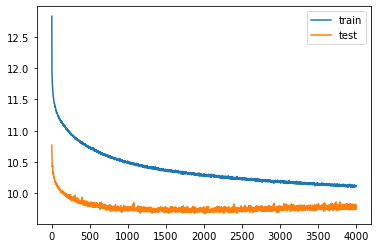

In [24]:
path = "C:/Users/Matt/Dropbox/SnowComp/RunGraphs/" 

suffix = "_" + \
    str(cdim1)+ "_" + str(cdim2)+ "_" +str(cdim3)+ "_" + str(kernel_sz)+ \
    "_" + str(dropout)+ "_" + str(ldim)+ "_" + str(epoch) +"_" + str(lrate)

plt.plot(range(epoch+1), np.sqrt(train_loss), label ="train")
plt.plot(range(epoch+1), np.sqrt(test_loss), label ="test")
plt.legend()
plt.savefig(path +"converge_alldata" + suffix+ ".png")

## Save Model and Predictions

### TODO: save image quality for random forest ingestion

In [25]:
pred_all = True

Rerun model on full dataset

In [26]:
del mini_x, mini_dataset, mini_loader

full_x = np.concatenate((train_dataset, dataset_test), axis = 0)
full_y = pd.concat((train_y, y_test), axis= 0)

#shuffle
full_y = full_y.reset_index(drop=True)

p = rng.permutation(len(full_x))
full_y = full_y.loc[p]
full_x = full_x[p]

full_y_og = full_y.copy()

In [27]:
full_y = np.array(full_y['snowpack'])

full_x, full_y = torch.Tensor(full_x), torch.Tensor(full_y)
full_dataset = TensorDataset(full_x, full_y)
full_loader = DataLoader(full_dataset, batch_size=128)

# del train_dataset, dataset_test, train_y, y_test

In [30]:
#@title Setup net
my_nn = Net(cdim1=cdim1, cdim2=cdim2,cdim3 =cdim3, kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_nn.to(device)

optimizer = optim.Adam(my_nn.parameters(), lr=lrate)
criterion = nn.MSELoss(reduction = 'sum')

c1 dim: 19
mp0 dim: 17
c2 dim: 15
mp1 dim: 13
c3 dim: 11
mp2 dim: 9
flattened_dim 648


In [31]:
train_loss = []

#@title Run net
for epoch in range(N_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(full_loader, 0):
        optimizer.zero_grad()
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = my_nn(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss.append(running_loss/train_rows)
    print(epoch, '/', N_EPOCHS,
          'complete, train:', round(np.sqrt(train_loss[-1]), 4),
          "test:", round(np.sqrt(test_loss[-1]), 4) )

0 / 4000 complete, train: 13.906 test: 9.8009
1 / 4000 complete, train: 13.1501 test: 9.8009
2 / 4000 complete, train: 13.0197 test: 9.8009
3 / 4000 complete, train: 12.9374 test: 9.8009
4 / 4000 complete, train: 12.8835 test: 9.8009
5 / 4000 complete, train: 12.8383 test: 9.8009
6 / 4000 complete, train: 12.797 test: 9.8009
7 / 4000 complete, train: 12.7648 test: 9.8009
8 / 4000 complete, train: 12.7345 test: 9.8009
9 / 4000 complete, train: 12.7039 test: 9.8009
10 / 4000 complete, train: 12.6807 test: 9.8009
11 / 4000 complete, train: 12.6591 test: 9.8009
12 / 4000 complete, train: 12.6427 test: 9.8009
13 / 4000 complete, train: 12.6201 test: 9.8009
14 / 4000 complete, train: 12.6105 test: 9.8009
15 / 4000 complete, train: 12.5884 test: 9.8009
16 / 4000 complete, train: 12.5832 test: 9.8009
17 / 4000 complete, train: 12.5739 test: 9.8009
18 / 4000 complete, train: 12.5624 test: 9.8009
19 / 4000 complete, train: 12.5543 test: 9.8009
20 / 4000 complete, train: 12.5335 test: 9.8009
21 /

170 / 4000 complete, train: 11.9996 test: 9.8009
171 / 4000 complete, train: 12.0061 test: 9.8009
172 / 4000 complete, train: 12.0039 test: 9.8009
173 / 4000 complete, train: 12.0037 test: 9.8009
174 / 4000 complete, train: 12.0105 test: 9.8009
175 / 4000 complete, train: 12.0083 test: 9.8009
176 / 4000 complete, train: 11.9987 test: 9.8009
177 / 4000 complete, train: 11.9949 test: 9.8009
178 / 4000 complete, train: 12.0045 test: 9.8009
179 / 4000 complete, train: 11.981 test: 9.8009
180 / 4000 complete, train: 11.9892 test: 9.8009
181 / 4000 complete, train: 11.9904 test: 9.8009
182 / 4000 complete, train: 11.9841 test: 9.8009
183 / 4000 complete, train: 11.9779 test: 9.8009
184 / 4000 complete, train: 11.9724 test: 9.8009
185 / 4000 complete, train: 11.9698 test: 9.8009
186 / 4000 complete, train: 11.9812 test: 9.8009
187 / 4000 complete, train: 11.9678 test: 9.8009
188 / 4000 complete, train: 11.9782 test: 9.8009
189 / 4000 complete, train: 11.9799 test: 9.8009
190 / 4000 complete, 

338 / 4000 complete, train: 11.7897 test: 9.8009
339 / 4000 complete, train: 11.7899 test: 9.8009
340 / 4000 complete, train: 11.7823 test: 9.8009
341 / 4000 complete, train: 11.7877 test: 9.8009
342 / 4000 complete, train: 11.8005 test: 9.8009
343 / 4000 complete, train: 11.7844 test: 9.8009
344 / 4000 complete, train: 11.7983 test: 9.8009
345 / 4000 complete, train: 11.7989 test: 9.8009
346 / 4000 complete, train: 11.7662 test: 9.8009
347 / 4000 complete, train: 11.7784 test: 9.8009
348 / 4000 complete, train: 11.7895 test: 9.8009
349 / 4000 complete, train: 11.7757 test: 9.8009
350 / 4000 complete, train: 11.7781 test: 9.8009
351 / 4000 complete, train: 11.7756 test: 9.8009
352 / 4000 complete, train: 11.7758 test: 9.8009
353 / 4000 complete, train: 11.7628 test: 9.8009
354 / 4000 complete, train: 11.7795 test: 9.8009
355 / 4000 complete, train: 11.7867 test: 9.8009
356 / 4000 complete, train: 11.7802 test: 9.8009
357 / 4000 complete, train: 11.7911 test: 9.8009
358 / 4000 complete,

506 / 4000 complete, train: 11.6763 test: 9.8009
507 / 4000 complete, train: 11.6689 test: 9.8009
508 / 4000 complete, train: 11.681 test: 9.8009
509 / 4000 complete, train: 11.6777 test: 9.8009
510 / 4000 complete, train: 11.6758 test: 9.8009
511 / 4000 complete, train: 11.6812 test: 9.8009
512 / 4000 complete, train: 11.6515 test: 9.8009
513 / 4000 complete, train: 11.6701 test: 9.8009
514 / 4000 complete, train: 11.6736 test: 9.8009
515 / 4000 complete, train: 11.6717 test: 9.8009
516 / 4000 complete, train: 11.6666 test: 9.8009
517 / 4000 complete, train: 11.657 test: 9.8009
518 / 4000 complete, train: 11.6581 test: 9.8009
519 / 4000 complete, train: 11.6563 test: 9.8009
520 / 4000 complete, train: 11.6725 test: 9.8009
521 / 4000 complete, train: 11.6801 test: 9.8009
522 / 4000 complete, train: 11.6652 test: 9.8009
523 / 4000 complete, train: 11.655 test: 9.8009
524 / 4000 complete, train: 11.6683 test: 9.8009
525 / 4000 complete, train: 11.6562 test: 9.8009
526 / 4000 complete, tr

674 / 4000 complete, train: 11.5899 test: 9.8009
675 / 4000 complete, train: 11.5882 test: 9.8009
676 / 4000 complete, train: 11.5714 test: 9.8009
677 / 4000 complete, train: 11.5751 test: 9.8009
678 / 4000 complete, train: 11.5954 test: 9.8009
679 / 4000 complete, train: 11.6037 test: 9.8009
680 / 4000 complete, train: 11.5846 test: 9.8009
681 / 4000 complete, train: 11.595 test: 9.8009
682 / 4000 complete, train: 11.5814 test: 9.8009
683 / 4000 complete, train: 11.5999 test: 9.8009
684 / 4000 complete, train: 11.5982 test: 9.8009
685 / 4000 complete, train: 11.5988 test: 9.8009
686 / 4000 complete, train: 11.5865 test: 9.8009
687 / 4000 complete, train: 11.5818 test: 9.8009
688 / 4000 complete, train: 11.5907 test: 9.8009
689 / 4000 complete, train: 11.5871 test: 9.8009
690 / 4000 complete, train: 11.5712 test: 9.8009
691 / 4000 complete, train: 11.5817 test: 9.8009
692 / 4000 complete, train: 11.5757 test: 9.8009
693 / 4000 complete, train: 11.5848 test: 9.8009
694 / 4000 complete, 

842 / 4000 complete, train: 11.5386 test: 9.8009
843 / 4000 complete, train: 11.5436 test: 9.8009
844 / 4000 complete, train: 11.5262 test: 9.8009
845 / 4000 complete, train: 11.5338 test: 9.8009
846 / 4000 complete, train: 11.5337 test: 9.8009
847 / 4000 complete, train: 11.5339 test: 9.8009
848 / 4000 complete, train: 11.5287 test: 9.8009
849 / 4000 complete, train: 11.5332 test: 9.8009
850 / 4000 complete, train: 11.5273 test: 9.8009
851 / 4000 complete, train: 11.528 test: 9.8009
852 / 4000 complete, train: 11.5202 test: 9.8009
853 / 4000 complete, train: 11.522 test: 9.8009
854 / 4000 complete, train: 11.5405 test: 9.8009
855 / 4000 complete, train: 11.5322 test: 9.8009
856 / 4000 complete, train: 11.5344 test: 9.8009
857 / 4000 complete, train: 11.5224 test: 9.8009
858 / 4000 complete, train: 11.5153 test: 9.8009
859 / 4000 complete, train: 11.5281 test: 9.8009
860 / 4000 complete, train: 11.5279 test: 9.8009
861 / 4000 complete, train: 11.5381 test: 9.8009
862 / 4000 complete, t

1010 / 4000 complete, train: 11.4723 test: 9.8009
1011 / 4000 complete, train: 11.4794 test: 9.8009
1012 / 4000 complete, train: 11.4802 test: 9.8009
1013 / 4000 complete, train: 11.4912 test: 9.8009
1014 / 4000 complete, train: 11.4828 test: 9.8009
1015 / 4000 complete, train: 11.4826 test: 9.8009
1016 / 4000 complete, train: 11.4662 test: 9.8009
1017 / 4000 complete, train: 11.4744 test: 9.8009
1018 / 4000 complete, train: 11.4775 test: 9.8009
1019 / 4000 complete, train: 11.4845 test: 9.8009
1020 / 4000 complete, train: 11.479 test: 9.8009
1021 / 4000 complete, train: 11.4933 test: 9.8009
1022 / 4000 complete, train: 11.4758 test: 9.8009
1023 / 4000 complete, train: 11.4804 test: 9.8009
1024 / 4000 complete, train: 11.4787 test: 9.8009
1025 / 4000 complete, train: 11.4814 test: 9.8009
1026 / 4000 complete, train: 11.4808 test: 9.8009
1027 / 4000 complete, train: 11.4805 test: 9.8009
1028 / 4000 complete, train: 11.4631 test: 9.8009
1029 / 4000 complete, train: 11.4793 test: 9.8009
1

1175 / 4000 complete, train: 11.4583 test: 9.8009
1176 / 4000 complete, train: 11.4378 test: 9.8009
1177 / 4000 complete, train: 11.4482 test: 9.8009
1178 / 4000 complete, train: 11.443 test: 9.8009
1179 / 4000 complete, train: 11.45 test: 9.8009
1180 / 4000 complete, train: 11.4369 test: 9.8009
1181 / 4000 complete, train: 11.4497 test: 9.8009
1182 / 4000 complete, train: 11.4298 test: 9.8009
1183 / 4000 complete, train: 11.4471 test: 9.8009
1184 / 4000 complete, train: 11.4418 test: 9.8009
1185 / 4000 complete, train: 11.444 test: 9.8009
1186 / 4000 complete, train: 11.4359 test: 9.8009
1187 / 4000 complete, train: 11.4369 test: 9.8009
1188 / 4000 complete, train: 11.4506 test: 9.8009
1189 / 4000 complete, train: 11.4326 test: 9.8009
1190 / 4000 complete, train: 11.4396 test: 9.8009
1191 / 4000 complete, train: 11.4485 test: 9.8009
1192 / 4000 complete, train: 11.4427 test: 9.8009
1193 / 4000 complete, train: 11.4393 test: 9.8009
1194 / 4000 complete, train: 11.4396 test: 9.8009
1195

1340 / 4000 complete, train: 11.3943 test: 9.8009
1341 / 4000 complete, train: 11.4242 test: 9.8009
1342 / 4000 complete, train: 11.4164 test: 9.8009
1343 / 4000 complete, train: 11.4194 test: 9.8009
1344 / 4000 complete, train: 11.4174 test: 9.8009
1345 / 4000 complete, train: 11.407 test: 9.8009
1346 / 4000 complete, train: 11.422 test: 9.8009
1347 / 4000 complete, train: 11.4328 test: 9.8009
1348 / 4000 complete, train: 11.418 test: 9.8009
1349 / 4000 complete, train: 11.4195 test: 9.8009
1350 / 4000 complete, train: 11.4118 test: 9.8009
1351 / 4000 complete, train: 11.4093 test: 9.8009
1352 / 4000 complete, train: 11.4109 test: 9.8009
1353 / 4000 complete, train: 11.4088 test: 9.8009
1354 / 4000 complete, train: 11.4208 test: 9.8009
1355 / 4000 complete, train: 11.4081 test: 9.8009
1356 / 4000 complete, train: 11.4125 test: 9.8009
1357 / 4000 complete, train: 11.4029 test: 9.8009
1358 / 4000 complete, train: 11.395 test: 9.8009
1359 / 4000 complete, train: 11.3989 test: 9.8009
1360

In [32]:
torch.cuda.empty_cache()

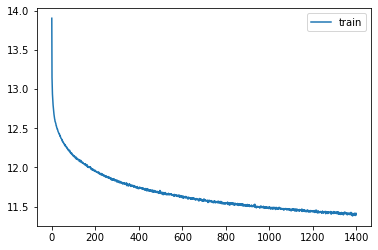

In [33]:
path = "C:/Users/Matt/Dropbox/SnowComp/RunGraphs/" 

suffix = "_" + \
    str(cdim1)+ "_" + str(cdim2)+ "_" +str(cdim3)+ "_" + str(kernel_sz)+ \
    "_" + str(dropout)+ "_" + str(ldim)+ "_" + str(epoch) +"_" + str(lrate) 

plt.plot(range(epoch+1), np.sqrt(train_loss), label ="train")
plt.legend()
plt.savefig(path +"full" + suffix+ ".png")

### Save predictions

In [ ]:
if pred_all:
    my_nn.eval()
    my_nn.to('cpu')

    torch.save(my_nn.state_dict(), path +"model"+suffix)
    
    with torch.no_grad():
        vals = my_nn(full_x).detach().numpy()
        
    path_preds = "C:/Users/Matt/Dropbox/SnowComp/preds/" 
    np.save(path_preds+"preds.npy", vals)
    full_y_og.to_csv(path_preds+"yvals.csv")
    
    #Predict and save on submission data
    vals_sub = []

    sub_dataset = np.load(path5)
    sub_dataset = torch.Tensor(sub_dataset)
    sub_ds = TensorDataset(sub_dataset)
    sub_loader = DataLoader(sub_ds, batch_size=50000)

    with torch.no_grad():
        for images in sub_loader:
            vals_sub.append(my_nn(images[0]).detach().numpy()) 

    vals_sub = np.concatenate(vals_sub, axis = 0)        
    np.save(path_preds+"subpred.npy", vals_sub)
    
    #calculate image quality
    image_qual = full_x.detach().numpy()
    image_qual = np.sum(image_qual, axis= (1,2,3))
    np.save(path_preds +"image_qual_train.npy", image_qual)
    
    image_qual = np.sum(sub_dataset.detach().numpy(), axis= (1,2,3))
    np.save(path_preds +"image_qual_sub.npy", image_qual)    
    

## Things to check

1. Accuracy measures are right
2. Check missing value

### TODO:
- Add test set/cv
- Batchnorm?
- CNN benchmark